Import das bibliotecas necessárias para execução e criação dos modelos

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 1

In [3]:
#Load dataset
def load_dataset(path=r'../Datasets_utilizados/dataset_final.csv'):
    return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
    train_idx = np.arange(0, int(len(training)*(100-perc)/100))
    val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
    return train_idx, val_idx

In [5]:
def prepare_data(df):
    df_aux = df.copy()
    df_aux["Date"] = pd.to_datetime(df_aux["Date"])
    df_aux = df_aux.set_index('Date')
    return df_aux

In [6]:
# def data_normalization(df, norm_range=(-1, 1)):
#   #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
#   scaler = MinMaxScaler(feature_range=norm_range)
#   df = scaler.fit_transform(df)
#   return scaler

In [7]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    colunas = [x for x in df.columns if x != 'obitos']
    for col in colunas:
        df[[col]] = scaler.fit_transform(df[[col]])
    df[['obitos']] = scaler.fit_transform(df[['obitos']])
    return scaler

In [8]:
#plot learning curve
def plot_learning_curves(history, epochs):
    #accuracies and losses
    #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    mae=history.history['mae']
    val_mae=history.history['val_mae']
    rmse=history.history['rmse']
    val_rmse=history.history['val_rmse']
    epochs_range = range(epochs)
    #creating figure
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,2)
    plt.plot(epochs_range,loss,label='Training Loss')
    plt.plot(epochs_range,val_loss,label='Validation Loss')
    # plt.plot(epochs_range,mae,label='Training MAE')
    # plt.plot(epochs_range,val_mae,label='Validation MAE')
    # plt.plot(epochs_range,rmse,label='Training RMSE')
    # plt.plot(epochs_range,val_rmse,label='Validation RMSE')
    plt.legend(loc='upper right')
    plt.title('Training/Validation Loss')
    plt.show()

In [9]:
#Plot time series data
def plot_confirmed_cases(data):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(data)), data)
    plt.title('Confirmed Cases of COVID-19')
    plt.ylabel('Cases')
    plt.xlabel('Days')
    plt.show()

In [10]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
    data = df.values
    X, y = list(), list()
    #iterate over the training set to create X and y
    dataset_size = len(data)
    for curr_pos in range(dataset_size):
        #end of the input sequence is the current position + the number of timesteps of the input sequence
        input_index = curr_pos + timesteps
        #end of the labels corresponds to the end of the input sequence + 1
        label_index = input_index + 1
        #if we have enough data for this sequence
        if label_index < dataset_size:
            X.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 76])
        # y.append(data[input_index:label_index, 0:n_variate])

    #using np.float32 for GPU performance
    return np.array(X).astype('float32'), np.array(y).astype('float32')

In [11]:
#Building the model
def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [12]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
    #Add a new layer
    model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
    #
    model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
    # model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
    #model summary (and save it as PNG)
    tf.keras.utils.plot_model(model, 'Covid_model.png', show_shapes=True)
    return model

In [13]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size, learning_rate):
    #compile
    model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['mae', rmse])
    #fit
    hist_list = list()
    loss_list = list()

    #callback
    #saving in Keras HDF5 (or h5), a binary data format
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
                save_best_only=True,#overwrite the current checkpoint if and only if
                monitor='val_loss',#the val_loss score has improved
                save_weights_only=False,#if True, only the weigths are saved
                verbose=1,#verbosity mode
                period=5 #save ony at the fifth epoch (5 em 5 epocas)
                )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

    #Time Series Cross Validator
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    for train_index, test_index in tscv.split(X):
        train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
        #build data
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        X_test, y_test = X[test_index], y[test_index]

        #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False)
        # history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
        metrics = model.evaluate(X_test, y_test)


        plot_learning_curves(history, epochs)
        hist_list.append(history)


    return model, hist_list

In [14]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)

scaler = data_normalization(df) #scaling data to [-1, 1]

In [15]:
df

,confirmados_novos,recuperados,Temperature,Visibility,total_testes,testes_pcr,testes_antigenio,new_cases_per_million_Austria,new_deaths_per_million_Austria,new_cases_per_million_Belgium,...,new_deaths_per_million_United Arab Emirates,tests_per_case_United Arab Emirates,new_cases_per_million_United Kingdom,new_deaths_per_million_United Kingdom,icu_patients_per_million_United Kingdom,hosp_patients_per_million_United Kingdom,positive_rate_United Kingdom,new_cases_per_million_United States,new_deaths_per_million_United States,obitos
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-26,-1.000000,-1.000000,-0.454545,0.861111,-1.000000,-1.000000,-1.000000,-1.000000,-0.990870,-1.000000,...,-1.000000,0.283484,-0.868730,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2020-02-27,-1.000000,-1.000000,-0.333333,0.722222,-1.000000,-1.000000,-1.000000,-0.999791,-0.990870,-1.000000,...,-1.000000,0.190274,-0.868620,-1.000000,-1.000000,-1.000000,-1.000000,-0.999993,-1.000000,-1.000000
2020-02-28,-1.000000,-1.000000,-0.424242,0.250000,-1.000000,-1.000000,-1.000000,-1.000000,-0.990870,-1.000000,...,-1.000000,0.081410,-0.868483,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2020-02-29,-1.000000,-1.000000,-0.287879,0.111111,-1.000000,-1.000000,-1.000000,-0.998749,-0.990870,-1.000000,...,-1.000000,0.005682,-0.868674,-1.000000,-1.000000,-1.000000,-1.000000,-0.999947,-0.999556,-1.000000
2020-03-01,-1.000000,-1.000000,-0.272727,0.083333,-0.999494,-0.999225,-1.000000,-0.998957,-0.990870,-0.999917,...,-1.000000,0.032063,-0.867908,-1.000000,-1.000000,-1.000000,-1.000000,-0.999954,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-18,-0.946324,-0.955042,-0.151515,0.472222,-0.707749,-0.628976,-0.926610,-0.566868,-0.735154,-0.749509,...,-0.600396,-0.940641,-0.817181,-0.989070,-0.847445,-0.899004,-0.980000,-0.719671,-0.849475,-0.980198
2021-04-19,-0.973223,-0.937742,-0.136364,0.694444,0.594345,-0.166860,0.549913,-0.558314,-0.771673,-0.863718,...,-0.800198,-0.942946,-0.785117,-0.993457,-0.844015,-0.897779,-0.986667,-0.546545,-0.775691,-0.993399
2021-04-20,-0.948393,-0.897337,-0.196970,0.833333,0.962914,-0.006057,0.938902,-0.577300,-0.652986,-0.713222,...,-0.700297,-0.946522,-0.799478,-0.963863,-0.852840,-0.901910,-0.986667,-0.594352,-0.624723,-0.966997


In [16]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
    input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
    inp = input_seq
    #print("Input_seq: ",inp)
    forecasts = list()

    #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
    for step in range(1, multisteps+1):
        inp = inp.reshape(1,timesteps,n_variate)
        yhat = model.predict(inp) #dá o valor predito normalizado
        yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
        forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
        # se for necessário prever mais do que 1 semana
        # list_yhat = [yhat[0][i] for i in range(len(yhat[0]))]
        # print('list_yhat:')
        # print(list_yhat)
        # #preparar novo input para fazer previsão para a semana seguinte
        # inp= np.append(inp[0],[list_yhat],axis=0) #adiciona previsão recente ao input
        # inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
        # print('forecasts:')
        # print(forecasts)
    return forecasts

In [17]:
def plot_forecast(data, forecasts):
    plt.figure(figsize=(20,8))
    plt.plot(range(len(data)), data['obitos'], color='green', label='True value')
    plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
    plt.title('Óbitos em Portugal')
    plt.ylabel('Número de Óbitos')
    plt.xlabel('Semanas')
    plt.legend()
    plt.show()

# Tunning

Dado que o tamanho vertical do dataset é reduzido caso se junte os dados por meses, é utilizado o dataset diário. Para fazer o treino destes modelos é utilizado o valor de timesteps de 30, para verificar o melhor, mas assim conseguimos treinar pelo mês anterior

In [20]:
tunning_dict = {               
                1: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 25,  'batch_size' : 1 , "learning_rate":0.001},
                2: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 2 ,"learning_rate":0.0001},
                3: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 3 ,"learning_rate":0.00001},

                
                4: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 1 ,"learning_rate":0.001},
                5: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                6: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001},
                
                7: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 1 ,"learning_rate":0.001},
                8: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                9: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001}

                }
# record da history de cada modelo
record = {}

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/25
90/90 [==============================] - 5s 23ms/step - loss: 0.1729 - mae: 0.1564 - rmse: 0.1729 - val_loss: 0.0204 - val_mae: 0.0179 - val_rmse: 0.0204
Epoch 2/25
90/90 [==============================] - 1s 13ms/step - loss: 0.0306 - mae: 0.0277 - rmse: 0.0306 - val_loss: 0.0257 - val_mae: 0.0215 - val_rmse: 0.0257
Epoch 3/25
90/90 [==============================] - 1s 13ms/step - loss: 0.0303 - mae: 0.0277 - rmse: 0.0303 - val_loss: 0.0235 - val_mae: 0.0195 - val_rmse: 0.0235
Epoch 4/25
90/90 [==============================] - 1s 12ms/step - loss: 0.0300 - mae: 0.0275 - rmse: 0.0300 - val_loss: 0.0218 - val_mae: 0.0184 - val_rmse: 0.0218
Epoch 5/25
90/90 [==============================] - 1s 13ms/step - loss: 0.0300 - mae: 0.0276 - rmse: 0.0300 - val_loss: 0.0214 - val_mae: 0.0182 - val_rmse: 0.0214
Epoch

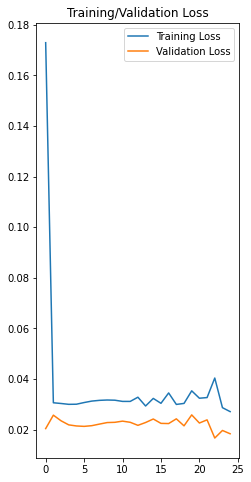

Epoch 1/25
177/177 [==============================] - 2s 12ms/step - loss: 0.0212 - mae: 0.0198 - rmse: 0.0212 - val_loss: 0.0212 - val_mae: 0.0208 - val_rmse: 0.0212
Epoch 2/25
177/177 [==============================] - 2s 12ms/step - loss: 0.0204 - mae: 0.0191 - rmse: 0.0204 - val_loss: 0.0218 - val_mae: 0.0215 - val_rmse: 0.0218
Epoch 3/25
177/177 [==============================] - 2s 12ms/step - loss: 0.0213 - mae: 0.0198 - rmse: 0.0213 - val_loss: 0.0225 - val_mae: 0.0221 - val_rmse: 0.0225
Epoch 4/25
177/177 [==============================] - 2s 12ms/step - loss: 0.0213 - mae: 0.0197 - rmse: 0.0213 - val_loss: 0.0231 - val_mae: 0.0227 - val_rmse: 0.0231
Epoch 5/25
177/177 [==============================] - 2s 12ms/step - loss: 0.0212 - mae: 0.0199 - rmse: 0.0212 - val_loss: 0.0236 - val_mae: 0.0232 - val_rmse: 0.0236
Epoch 6/25
177/177 [==============================] - 2s 12ms/step - loss: 0.0214 - mae: 0.0201 - rmse: 0.0214 - val_loss: 0.0234 - val_mae: 0.0231 - val_rmse: 0.023

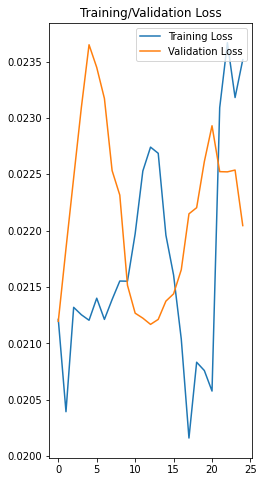

Epoch 1/25
264/264 [==============================] - 3s 13ms/step - loss: 0.0281 - mae: 0.0268 - rmse: 0.0281 - val_loss: 0.1788 - val_mae: 0.1778 - val_rmse: 0.1788
Epoch 2/25
264/264 [==============================] - 3s 12ms/step - loss: 0.0521 - mae: 0.0507 - rmse: 0.0521 - val_loss: 0.1315 - val_mae: 0.1300 - val_rmse: 0.1315
Epoch 3/25
264/264 [==============================] - 3s 12ms/step - loss: 0.0434 - mae: 0.0423 - rmse: 0.0434 - val_loss: 0.1382 - val_mae: 0.1374 - val_rmse: 0.1382
Epoch 4/25
264/264 [==============================] - 3s 12ms/step - loss: 0.0309 - mae: 0.0300 - rmse: 0.0309 - val_loss: 0.1445 - val_mae: 0.1441 - val_rmse: 0.1445
Epoch 5/25
264/264 [==============================] - 3s 12ms/step - loss: 0.0283 - mae: 0.0272 - rmse: 0.0283 - val_loss: 0.1457 - val_mae: 0.1456 - val_rmse: 0.1457
Epoch 6/25
264/264 [==============================] - 3s 12ms/step - loss: 0.0273 - mae: 0.0263 - rmse: 0.0273 - val_loss: 0.1405 - val_mae: 0.1401 - val_rmse: 0.140

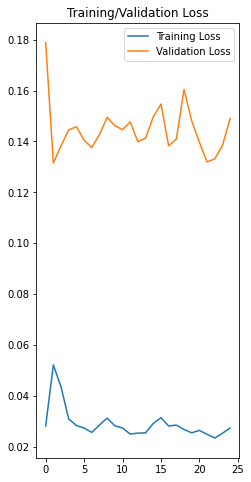

[array([[35.039593, 28.803032, 40.268322, 37.36282 , 35.774822, 32.430424,
        31.714077, 38.069843, 40.1794  , 37.08688 , 32.456413, 27.14424 ,
        32.196445, 31.909866, 33.761425, 38.05925 , 35.749367, 40.81763 ,
        32.756287, 34.469765, 37.241585, 37.83592 , 39.62374 , 38.970036,
        35.288036, 35.08896 , 34.093754, 40.913376, 31.802164, 36.152   ,
        40.986954, 28.920397, 33.330845, 32.773354, 34.483547, 34.537563,
        39.11133 , 39.15677 , 30.085335, 36.927498, 32.379234, 33.895397,
        36.36066 , 34.961582, 41.363285, 37.170048, 35.670002, 40.940186,
        38.661423, 35.976223, 40.785347, 39.019936, 37.045376, 40.303474,
        29.855284, 32.12937 , 36.062767, 33.862526, 36.9017  , 39.677128,
        34.084984, 40.09748 , 33.210617, 36.053493, 33.026684, 36.979862,
        36.929485, 32.614388, 38.28361 , 38.781685, 36.099945, 33.320423,
        33.57399 , 32.143864, 35.37814 , 41.141705, 38.36221 ]],
      dtype=float32)]
Previsões:
[35.039593]


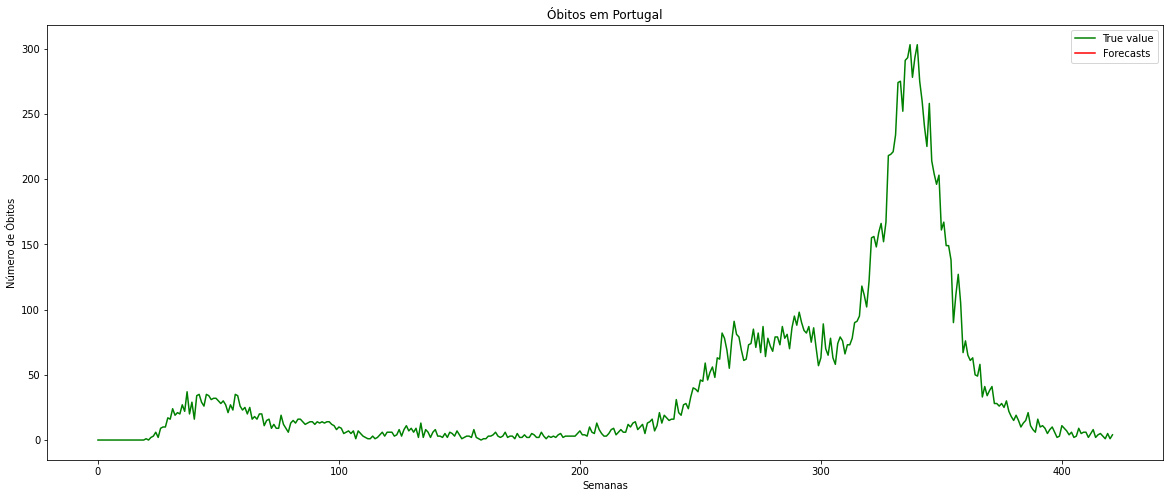

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/50
45/45 [==============================] - 5s 34ms/step - loss: 0.8126 - mae: 0.7982 - rmse: 0.8126 - val_loss: 0.7812 - val_mae: 0.7529 - val_rmse: 0.7808
Epoch 2/50
45/45 [==============================] - 1s 13ms/step - loss: 0.6088 - mae: 0.5552 - rmse: 0.6088 - val_loss: 0.5480 - val_mae: 0.4788 - val_rmse: 0.5476
Epoch 3/50
45/45 [==============================] - 1s 13ms/step - loss: 0.3814 - mae: 0.3120 - rmse: 0.3814 - val_loss: 0.3052 - val_mae: 0.2365 - val_rmse: 0.3048
Epoch 4/50
45/45 [==============================] - 1s 13ms/step - loss: 0.1772 - mae: 0.1299 - rmse: 0.1772 - val_loss: 0.1061 - val_mae: 0.0648 - val_rmse: 0.1058
Epoch 5/50
45/45 [==============================] - 1s 14ms/step - loss: 0.0743 - mae: 0.0642 - rmse: 0.0743 - val_loss: 0.0329 - val_mae: 0.0283 - val_rmse: 0.0330
Epoch

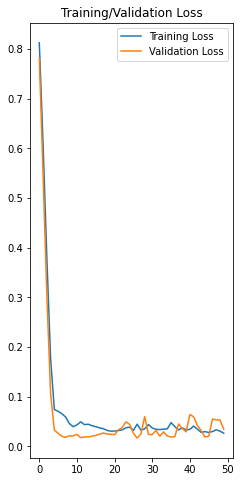

Epoch 1/50
89/89 [==============================] - 4s 15ms/step - loss: 0.0215 - mae: 0.0186 - rmse: 0.0214 - val_loss: 0.0233 - val_mae: 0.0217 - val_rmse: 0.0242
Epoch 2/50
89/89 [==============================] - 1s 14ms/step - loss: 0.0222 - mae: 0.0194 - rmse: 0.0221 - val_loss: 0.0240 - val_mae: 0.0223 - val_rmse: 0.0249
Epoch 3/50
89/89 [==============================] - 2s 18ms/step - loss: 0.0227 - mae: 0.0201 - rmse: 0.0226 - val_loss: 0.0234 - val_mae: 0.0218 - val_rmse: 0.0244
Epoch 4/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0236 - mae: 0.0209 - rmse: 0.0235 - val_loss: 0.0226 - val_mae: 0.0211 - val_rmse: 0.0235
Epoch 5/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0248 - mae: 0.0220 - rmse: 0.0246 - val_loss: 0.0219 - val_mae: 0.0205 - val_rmse: 0.0227
Epoch 6/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0224 - mae: 0.0197 - rmse: 0.0223 - val_loss: 0.0229 - val_mae: 0.0214 - val_rmse: 0.0239
Epoch 7/50

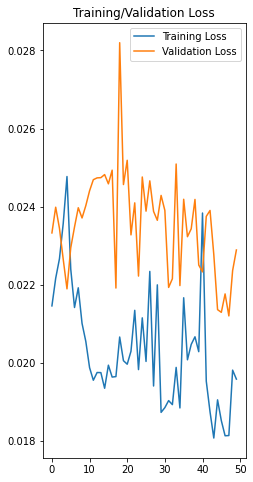

Epoch 1/50
132/132 [==============================] - 2s 13ms/step - loss: 0.0395 - mae: 0.0349 - rmse: 0.0395 - val_loss: 0.1624 - val_mae: 0.1450 - val_rmse: 0.1667
Epoch 2/50
132/132 [==============================] - 2s 13ms/step - loss: 0.0521 - mae: 0.0468 - rmse: 0.0521 - val_loss: 0.1886 - val_mae: 0.1710 - val_rmse: 0.1907
Epoch 3/50
132/132 [==============================] - 2s 12ms/step - loss: 0.0376 - mae: 0.0326 - rmse: 0.0376 - val_loss: 0.1429 - val_mae: 0.1283 - val_rmse: 0.1484
Epoch 4/50
132/132 [==============================] - 2s 13ms/step - loss: 0.0384 - mae: 0.0335 - rmse: 0.0384 - val_loss: 0.1450 - val_mae: 0.1315 - val_rmse: 0.1501
Epoch 5/50
132/132 [==============================] - 2s 12ms/step - loss: 0.0375 - mae: 0.0329 - rmse: 0.0375 - val_loss: 0.2082 - val_mae: 0.1965 - val_rmse: 0.2078
Epoch 6/50
132/132 [==============================] - 2s 12ms/step - loss: 0.0348 - mae: 0.0302 - rmse: 0.0348 - val_loss: 0.1735 - val_mae: 0.1629 - val_rmse: 0.175

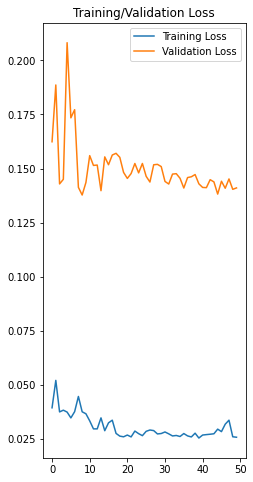

[array([[45.715332, 48.12741 , 51.58097 , 44.462334, 29.394415, 34.020058,
        49.65362 , 35.889904, 39.468353, 54.08904 , 27.034035, 49.986183,
        32.48718 , 40.367317, 35.3124  , 30.23798 , 32.368423, 38.08312 ,
        48.754242, 35.07911 , 22.824852, 45.91509 , 32.54881 , 35.916706,
        52.44836 , 37.95258 , 30.244183, 48.46482 , 39.488003, 45.566814,
        44.194004, 39.1592  , 39.340008, 43.75989 , 39.845795, 33.988552,
        44.840515, 32.968456, 25.004013, 59.55987 , 34.87667 , 41.166428,
        42.743877, 26.563143, 45.387783, 34.83951 , 44.676502, 26.997925,
        47.480656, 31.809254, 41.92285 , 39.396084, 38.032223, 29.090353,
        38.846195, 40.418728, 34.967224, 36.682808, 33.497005, 40.971306,
        40.405903, 45.038826, 35.484974, 27.19088 , 43.907562, 41.828335,
        28.528166, 33.229473, 39.304935, 27.812267, 52.590286, 37.203403,
        47.942844, 37.6389  , 54.85163 , 27.749844, 51.58509 ]],
      dtype=float32)]
Previsões:
[45.715332]


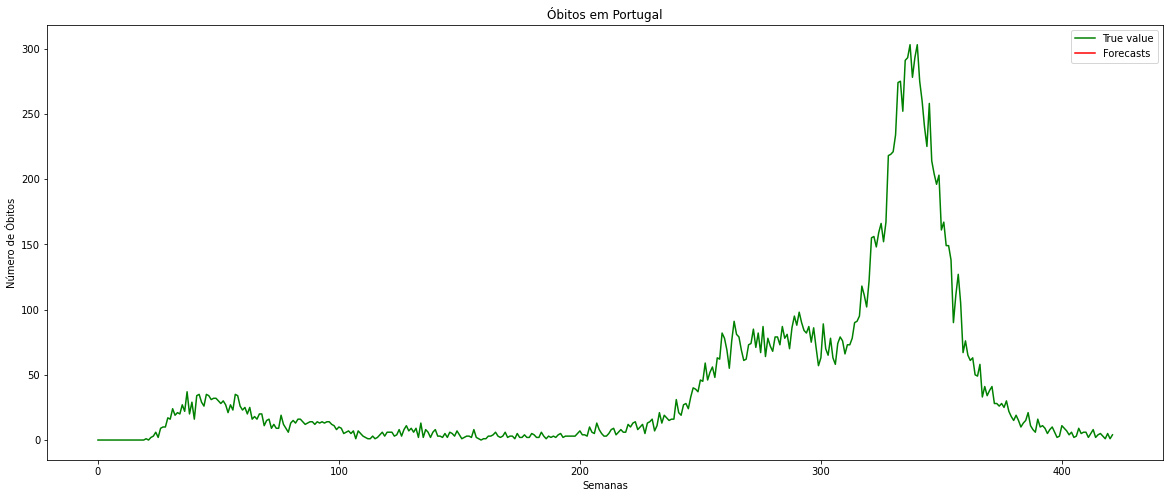

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/100
30/30 [==============================] - 4s 45ms/step - loss: 0.9102 - mae: 0.8864 - rmse: 0.9102 - val_loss: 0.9684 - val_mae: 0.9448 - val_rmse: 0.9684
Epoch 2/100
30/30 [==============================] - 0s 13ms/step - loss: 0.8964 - mae: 0.8734 - rmse: 0.8964 - val_loss: 0.9544 - val_mae: 0.9314 - val_rmse: 0.9544
Epoch 3/100
30/30 [==============================] - 0s 14ms/step - loss: 0.8827 - mae: 0.8603 - rmse: 0.8827 - val_loss: 0.9402 - val_mae: 0.9176 - val_rmse: 0.9402
Epoch 4/100
30/30 [==============================] - 0s 13ms/step - loss: 0.8687 - mae: 0.8468 - rmse: 0.8687 - val_loss: 0.9258 - val_mae: 0.9032 - val_rmse: 0.9258
Epoch 5/100
30/30 [==============================] - 0s 13ms/step - loss: 0.8545 - mae: 0.8326 - rmse: 0.8545 - val_loss: 0.9112 - val_mae: 0.8884 - val_rmse: 0.9112


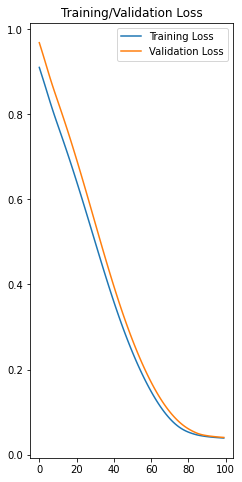

Epoch 1/100
59/59 [==============================] - 1s 14ms/step - loss: 0.0417 - mae: 0.0372 - rmse: 0.0417 - val_loss: 0.0268 - val_mae: 0.0218 - val_rmse: 0.0268
Epoch 2/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0388 - mae: 0.0344 - rmse: 0.0388 - val_loss: 0.0241 - val_mae: 0.0204 - val_rmse: 0.0251
Epoch 3/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0360 - mae: 0.0314 - rmse: 0.0360 - val_loss: 0.0244 - val_mae: 0.0213 - val_rmse: 0.0259
Epoch 4/100
59/59 [==============================] - 1s 13ms/step - loss: 0.0349 - mae: 0.0303 - rmse: 0.0349 - val_loss: 0.0254 - val_mae: 0.0225 - val_rmse: 0.0271
Epoch 5/100
59/59 [==============================] - 1s 13ms/step - loss: 0.0343 - mae: 0.0297 - rmse: 0.0343 - val_loss: 0.0261 - val_mae: 0.0233 - val_rmse: 0.0279
Epoch 6/100
59/59 [==============================] - 1s 13ms/step - loss: 0.0338 - mae: 0.0292 - rmse: 0.0338 - val_loss: 0.0265 - val_mae: 0.0238 - val_rmse: 0.0284
Epoc

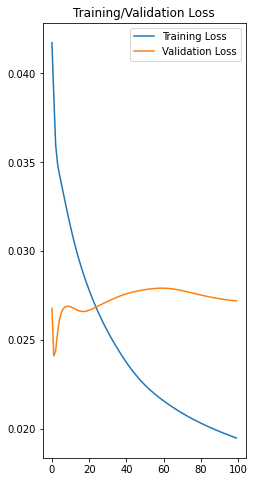

Epoch 1/100
88/88 [==============================] - 1s 13ms/step - loss: 0.0503 - mae: 0.0419 - rmse: 0.0503 - val_loss: 0.2674 - val_mae: 0.2320 - val_rmse: 0.2630
Epoch 2/100
88/88 [==============================] - 1s 13ms/step - loss: 0.0432 - mae: 0.0357 - rmse: 0.0432 - val_loss: 0.2250 - val_mae: 0.1932 - val_rmse: 0.2223
Epoch 3/100
88/88 [==============================] - 1s 13ms/step - loss: 0.0413 - mae: 0.0343 - rmse: 0.0413 - val_loss: 0.2199 - val_mae: 0.1892 - val_rmse: 0.2173
Epoch 4/100
88/88 [==============================] - 1s 13ms/step - loss: 0.0398 - mae: 0.0331 - rmse: 0.0398 - val_loss: 0.2155 - val_mae: 0.1856 - val_rmse: 0.2131
Epoch 5/100
88/88 [==============================] - 1s 13ms/step - loss: 0.0386 - mae: 0.0320 - rmse: 0.0386 - val_loss: 0.2130 - val_mae: 0.1836 - val_rmse: 0.2107
Epoch 6/100
88/88 [==============================] - 1s 13ms/step - loss: 0.0374 - mae: 0.0310 - rmse: 0.0374 - val_loss: 0.2112 - val_mae: 0.1822 - val_rmse: 0.2089
Epoc

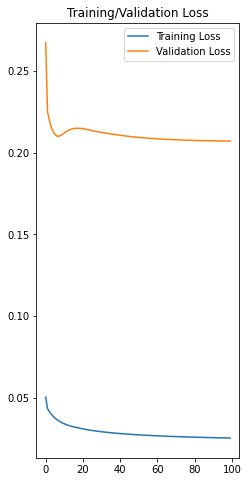

[array([[80.61018 , 67.30565 , 75.6362  , 45.34398 , 93.958374, 77.08358 ,
        32.012123, 52.835987, 45.647446, 81.98992 , 66.32645 , 67.78268 ,
        69.65647 , 46.01197 , 66.02347 , 77.47569 , 62.948807, 58.80418 ,
        68.22009 , 34.416824, 79.87728 , 80.45344 , 59.91369 , 57.24906 ,
        60.697857, 51.89828 , 58.65355 , 63.363407, 96.97585 , 74.62439 ,
        78.22076 , 81.79407 , 73.265465, 55.871788, 68.158295, 37.583282,
        68.36072 , 83.53845 , 75.351494, 41.60995 , 80.564095, 69.25743 ,
        54.18765 , 75.08887 , 70.661644, 80.13956 , 70.54914 , 72.569466,
        75.62007 , 72.74947 , 87.05215 , 69.67272 , 77.26778 , 70.81919 ,
        89.48829 , 65.24408 , 87.38444 , 79.71376 , 83.581665, 54.30084 ,
        51.10933 , 92.6541  , 65.39149 , 60.10947 , 56.621937, 45.972466,
        68.88131 , 59.124813, 79.3516  , 61.2137  , 61.413464, 66.560234,
        46.714577, 82.74418 , 58.443172, 76.23488 , 62.03113 ]],
      dtype=float32)]
Previsões:
[80.61018]


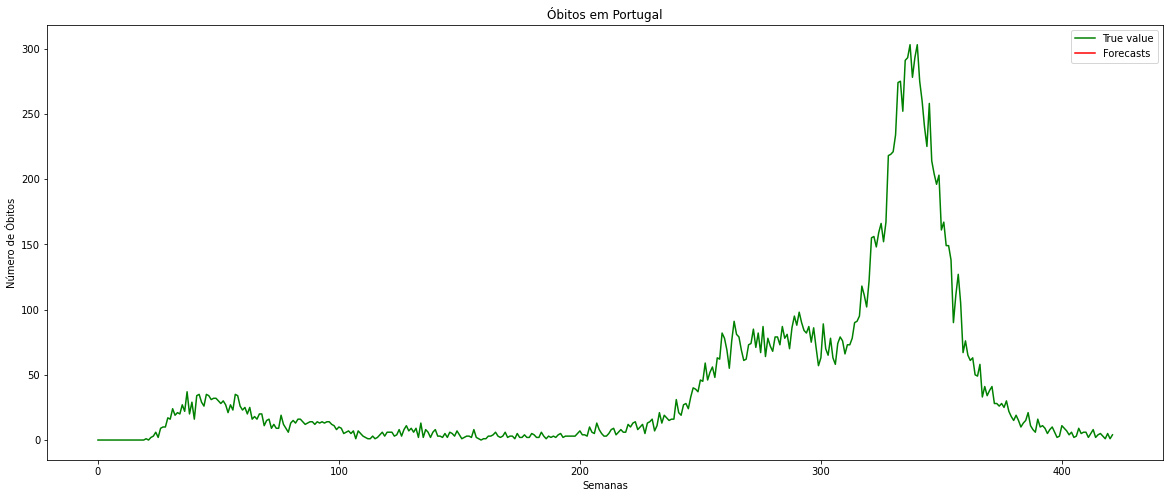

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/60
90/90 [==============================] - 5s 22ms/step - loss: 0.1491 - mae: 0.1315 - rmse: 0.1491 - val_loss: 0.0224 - val_mae: 0.0202 - val_rmse: 0.0224
Epoch 2/60
90/90 [==============================] - 1s 12ms/step - loss: 0.0316 - mae: 0.0288 - rmse: 0.0316 - val_loss: 0.0234 - val_mae: 0.0195 - val_rmse: 0.0234
Epoch 3/60
90/90 [==============================] - 1s 12ms/step - loss: 0.0309 - mae: 0.0284 - rmse: 0.0309 - val_loss: 0.0231 - val_mae: 0.0193 - val_rmse: 0.0231
Epoch 4/60
90/90 [==============================] - 1s 11ms/step - loss: 0.0283 - mae: 0.0262 - rmse: 0.0283 - val_loss: 0.0196 - val_mae: 0.0168 - val_rmse: 0.0196
Epoch 5/60
90/90 [==============================] - 1s 12ms/step - loss: 0.0278 - mae: 0.0261 - rmse: 0.0278 - val_loss: 0.0190 - val_mae: 0.0164 - val_rmse: 0.0190
Epoch

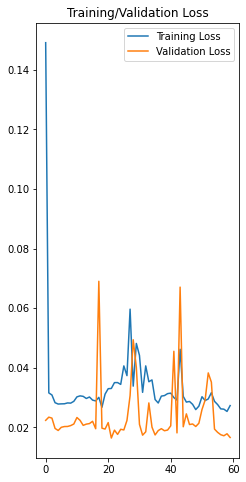

Epoch 1/60
177/177 [==============================] - 2s 12ms/step - loss: 0.0204 - mae: 0.0190 - rmse: 0.0204 - val_loss: 0.0232 - val_mae: 0.0226 - val_rmse: 0.0232
Epoch 2/60
177/177 [==============================] - 2s 12ms/step - loss: 0.0206 - mae: 0.0192 - rmse: 0.0206 - val_loss: 0.0232 - val_mae: 0.0227 - val_rmse: 0.0232
Epoch 3/60
177/177 [==============================] - 2s 11ms/step - loss: 0.0202 - mae: 0.0188 - rmse: 0.0202 - val_loss: 0.0233 - val_mae: 0.0228 - val_rmse: 0.0233
Epoch 4/60
177/177 [==============================] - 2s 12ms/step - loss: 0.0201 - mae: 0.0187 - rmse: 0.0201 - val_loss: 0.0234 - val_mae: 0.0230 - val_rmse: 0.0234
Epoch 5/60
177/177 [==============================] - 2s 12ms/step - loss: 0.0203 - mae: 0.0188 - rmse: 0.0203 - val_loss: 0.0237 - val_mae: 0.0235 - val_rmse: 0.0237
Epoch 6/60
177/177 [==============================] - 2s 12ms/step - loss: 0.0201 - mae: 0.0187 - rmse: 0.0201 - val_loss: 0.0241 - val_mae: 0.0237 - val_rmse: 0.024

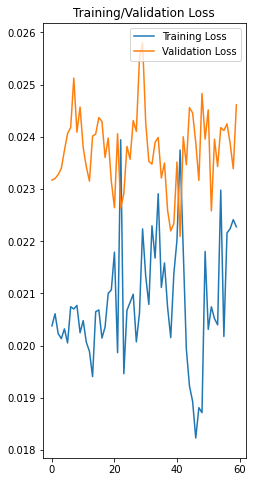

Epoch 1/60
264/264 [==============================] - 3s 12ms/step - loss: 0.0268 - mae: 0.0262 - rmse: 0.0268 - val_loss: 0.1554 - val_mae: 0.1543 - val_rmse: 0.1554
Epoch 2/60
264/264 [==============================] - 3s 12ms/step - loss: 0.0573 - mae: 0.0562 - rmse: 0.0573 - val_loss: 0.1576 - val_mae: 0.1564 - val_rmse: 0.1576
Epoch 3/60
264/264 [==============================] - 3s 12ms/step - loss: 0.0438 - mae: 0.0429 - rmse: 0.0438 - val_loss: 0.1883 - val_mae: 0.1875 - val_rmse: 0.1883
Epoch 4/60
264/264 [==============================] - 3s 12ms/step - loss: 0.0344 - mae: 0.0336 - rmse: 0.0344 - val_loss: 0.1672 - val_mae: 0.1668 - val_rmse: 0.1672
Epoch 5/60
264/264 [==============================] - 3s 12ms/step - loss: 0.0297 - mae: 0.0287 - rmse: 0.0297 - val_loss: 0.1530 - val_mae: 0.1527 - val_rmse: 0.1530
Epoch 6/60
264/264 [==============================] - 3s 12ms/step - loss: 0.0287 - mae: 0.0277 - rmse: 0.0287 - val_loss: 0.1431 - val_mae: 0.1430 - val_rmse: 0.143

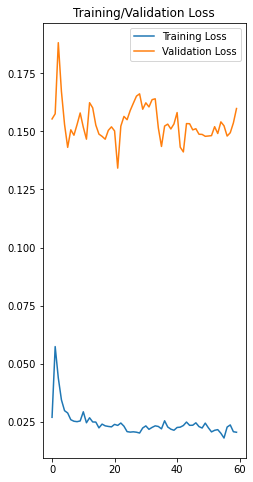

[array([[50.819275, 50.843746, 50.26991 , 50.89202 , 51.174255, 51.91766 ,
        50.043156, 50.953163, 50.766197, 50.92082 , 50.821495, 51.474056,
        50.578323, 48.84134 , 48.716125, 49.4628  , 50.66422 , 51.132484,
        50.93167 , 50.554405, 50.382282, 47.52337 , 50.19345 , 51.246407,
        49.303192, 50.990772, 51.505157, 50.107838, 51.029865, 49.53773 ,
        50.480843, 50.28879 , 50.355858, 51.371284, 47.069977, 51.34602 ,
        49.94845 , 49.712345, 51.478924, 48.673832, 49.879395, 49.32656 ,
        52.228405, 50.30099 , 49.920002, 50.388195, 48.376503, 51.24658 ,
        49.852196, 49.833385, 50.819004, 51.13975 , 49.827156, 49.25907 ,
        51.147022, 50.145645, 50.339214, 51.88696 , 50.833794, 51.358364,
        51.313744, 49.2796  , 51.26779 , 49.637955, 50.914875, 51.13355 ,
        51.900204, 49.947453, 50.91652 , 50.52641 , 50.5403  , 49.52099 ,
        49.75374 , 50.140236, 51.427895, 49.8085  , 51.342567]],
      dtype=float32)]
Previsões:
[50.819275]


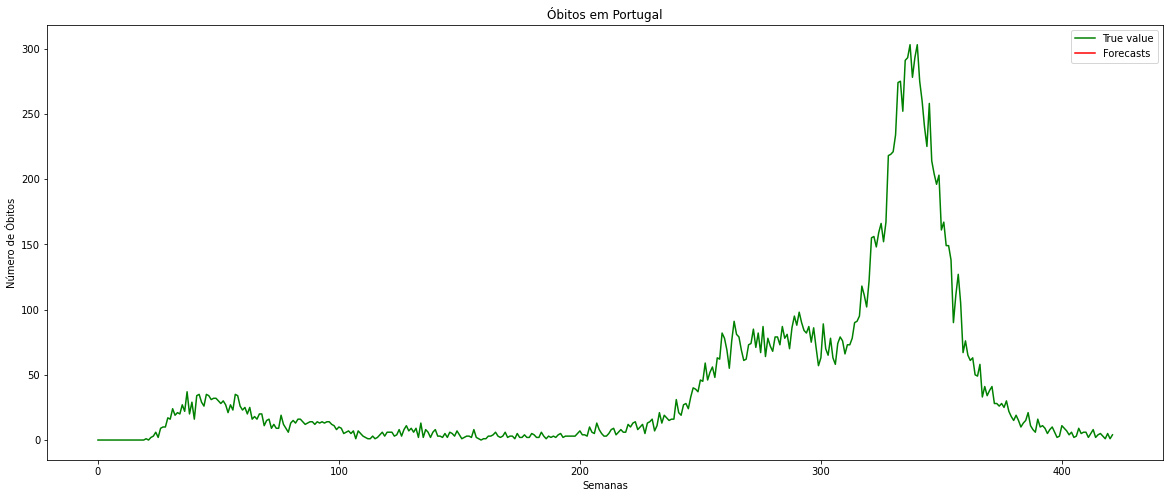

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/90
45/45 [==============================] - 5s 49ms/step - loss: 0.8361 - mae: 0.8233 - rmse: 0.8361 - val_loss: 0.8368 - val_mae: 0.8164 - val_rmse: 0.8363
Epoch 2/90
45/45 [==============================] - 1s 15ms/step - loss: 0.6886 - mae: 0.6442 - rmse: 0.6886 - val_loss: 0.6442 - val_mae: 0.5780 - val_rmse: 0.6437
Epoch 3/90
45/45 [==============================] - 1s 16ms/step - loss: 0.4728 - mae: 0.3984 - rmse: 0.4728 - val_loss: 0.3989 - val_mae: 0.3197 - val_rmse: 0.3985
Epoch 4/90
45/45 [==============================] - 1s 18ms/step - loss: 0.2469 - mae: 0.1864 - rmse: 0.2469 - val_loss: 0.1677 - val_mae: 0.1113 - val_rmse: 0.1673
Epoch 5/90
45/45 [==============================] - 1s 14ms/step - loss: 0.0891 - mae: 0.0730 - rmse: 0.0891 - val_loss: 0.0337 - val_mae: 0.0273 - val_rmse: 0.0336
Epoch

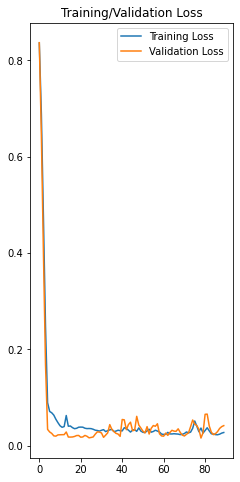

Epoch 1/90
89/89 [==============================] - 4s 16ms/step - loss: 0.0224 - mae: 0.0198 - rmse: 0.0223 - val_loss: 0.0237 - val_mae: 0.0221 - val_rmse: 0.0247
Epoch 2/90
89/89 [==============================] - 1s 15ms/step - loss: 0.0204 - mae: 0.0179 - rmse: 0.0203 - val_loss: 0.0232 - val_mae: 0.0218 - val_rmse: 0.0241
Epoch 3/90
89/89 [==============================] - 1s 15ms/step - loss: 0.0204 - mae: 0.0178 - rmse: 0.0203 - val_loss: 0.0239 - val_mae: 0.0225 - val_rmse: 0.0249
Epoch 4/90
89/89 [==============================] - 1s 15ms/step - loss: 0.0207 - mae: 0.0181 - rmse: 0.0206 - val_loss: 0.0237 - val_mae: 0.0224 - val_rmse: 0.0248
Epoch 5/90
89/89 [==============================] - 1s 15ms/step - loss: 0.0204 - mae: 0.0179 - rmse: 0.0203 - val_loss: 0.0234 - val_mae: 0.0221 - val_rmse: 0.0244
Epoch 6/90
89/89 [==============================] - 1s 15ms/step - loss: 0.0203 - mae: 0.0177 - rmse: 0.0203 - val_loss: 0.0230 - val_mae: 0.0217 - val_rmse: 0.0239
Epoch 7/90

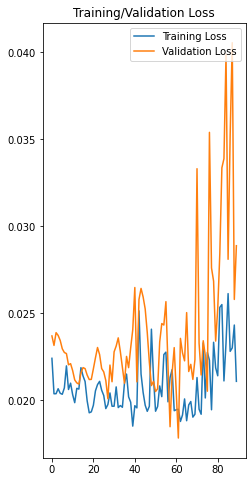

Epoch 1/90
132/132 [==============================] - 2s 13ms/step - loss: 0.0433 - mae: 0.0374 - rmse: 0.0433 - val_loss: 0.1846 - val_mae: 0.1621 - val_rmse: 0.1904
Epoch 2/90
132/132 [==============================] - 2s 13ms/step - loss: 0.0636 - mae: 0.0581 - rmse: 0.0636 - val_loss: 0.1885 - val_mae: 0.1759 - val_rmse: 0.1973
Epoch 3/90
132/132 [==============================] - 2s 13ms/step - loss: 0.0405 - mae: 0.0355 - rmse: 0.0405 - val_loss: 0.1652 - val_mae: 0.1495 - val_rmse: 0.1727
Epoch 4/90
132/132 [==============================] - 2s 13ms/step - loss: 0.0347 - mae: 0.0301 - rmse: 0.0347 - val_loss: 0.1742 - val_mae: 0.1594 - val_rmse: 0.1807
Epoch 5/90
132/132 [==============================] - 2s 12ms/step - loss: 0.0327 - mae: 0.0280 - rmse: 0.0327 - val_loss: 0.1948 - val_mae: 0.1813 - val_rmse: 0.2017
Epoch 6/90
132/132 [==============================] - 2s 13ms/step - loss: 0.0435 - mae: 0.0389 - rmse: 0.0435 - val_loss: 0.1999 - val_mae: 0.1920 - val_rmse: 0.210

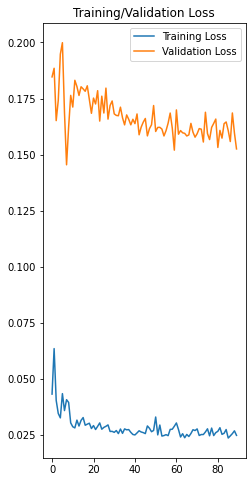

[array([[49.539818, 49.601166, 50.57436 , 56.230293, 55.039772, 45.436558,
        55.692856, 57.762005, 51.589046, 52.94432 , 53.268265, 59.691162,
        48.268738, 63.43822 , 56.879215, 52.19192 , 56.143024, 42.21585 ,
        47.124245, 52.112595, 52.222435, 54.65941 , 51.51163 , 53.41161 ,
        50.750538, 49.93531 , 49.73017 , 47.616394, 55.628014, 55.76965 ,
        57.757202, 54.409103, 56.030277, 55.14054 , 48.283577, 54.10849 ,
        52.270855, 54.570568, 53.005688, 53.16332 , 56.96706 , 58.723812,
        61.88245 , 58.05071 , 54.45    , 52.36278 , 47.277245, 51.46125 ,
        51.608974, 58.58557 , 49.520294, 56.408314, 51.502815, 55.233128,
        53.19234 , 47.611374, 51.595158, 50.66198 , 49.648403, 48.489796,
        52.65637 , 54.87929 , 55.769974, 56.7783  , 49.520664, 56.00668 ,
        56.048717, 62.528175, 52.906647, 57.85946 , 50.78787 , 54.880203,
        62.134834, 61.16669 , 61.51127 , 58.743633, 58.21202 ]],
      dtype=float32)]
Previsões:
[49.539818]


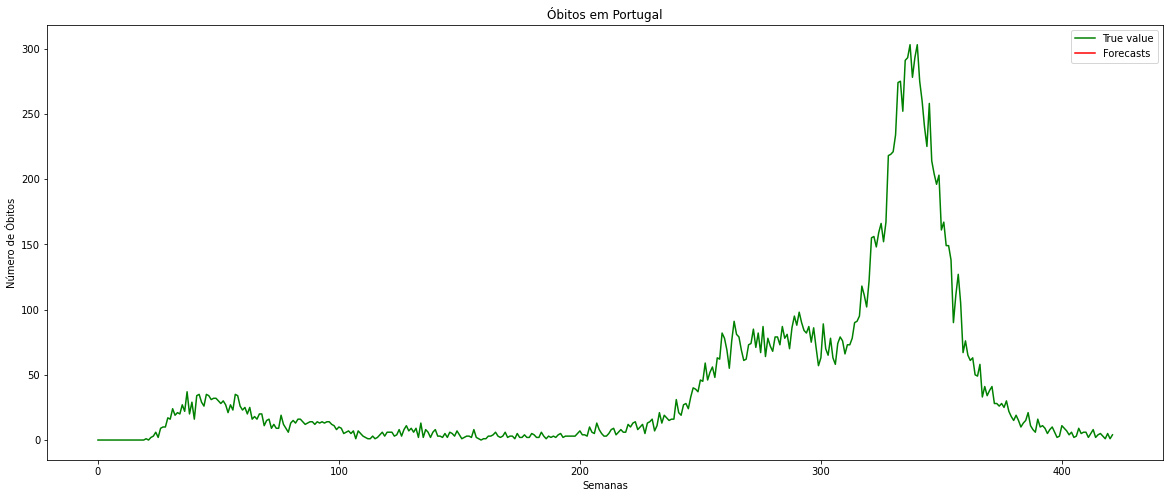

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/120
30/30 [==============================] - 5s 45ms/step - loss: 0.8997 - mae: 0.8894 - rmse: 0.8997 - val_loss: 0.9512 - val_mae: 0.9361 - val_rmse: 0.9512
Epoch 2/120
30/30 [==============================] - 0s 13ms/step - loss: 0.8875 - mae: 0.8776 - rmse: 0.8875 - val_loss: 0.9376 - val_mae: 0.9225 - val_rmse: 0.9376
Epoch 3/120
30/30 [==============================] - 0s 14ms/step - loss: 0.8756 - mae: 0.8659 - rmse: 0.8756 - val_loss: 0.9242 - val_mae: 0.9085 - val_rmse: 0.9242
Epoch 4/120
30/30 [==============================] - 0s 14ms/step - loss: 0.8637 - mae: 0.8537 - rmse: 0.8637 - val_loss: 0.9116 - val_mae: 0.8946 - val_rmse: 0.9116
Epoch 5/120
30/30 [==============================] - 0s 14ms/step - loss: 0.8519 - mae: 0.8410 - rmse: 0.8519 - val_loss: 0.9002 - val_mae: 0.8813 - val_rmse: 0.9002


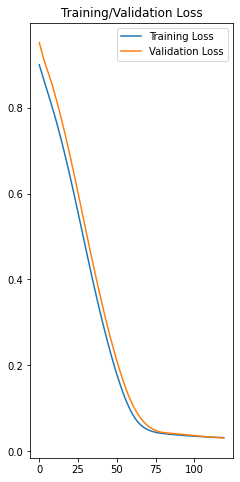

Epoch 1/120
59/59 [==============================] - 1s 14ms/step - loss: 0.0343 - mae: 0.0296 - rmse: 0.0343 - val_loss: 0.0276 - val_mae: 0.0225 - val_rmse: 0.0280
Epoch 2/120
59/59 [==============================] - 1s 14ms/step - loss: 0.0312 - mae: 0.0267 - rmse: 0.0312 - val_loss: 0.0251 - val_mae: 0.0214 - val_rmse: 0.0262
Epoch 3/120
59/59 [==============================] - 1s 12ms/step - loss: 0.0299 - mae: 0.0255 - rmse: 0.0299 - val_loss: 0.0241 - val_mae: 0.0211 - val_rmse: 0.0255
Epoch 4/120
59/59 [==============================] - 1s 13ms/step - loss: 0.0302 - mae: 0.0260 - rmse: 0.0302 - val_loss: 0.0246 - val_mae: 0.0216 - val_rmse: 0.0260
Epoch 5/120
59/59 [==============================] - 1s 12ms/step - loss: 0.0286 - mae: 0.0245 - rmse: 0.0286 - val_loss: 0.0250 - val_mae: 0.0220 - val_rmse: 0.0265
Epoch 6/120
59/59 [==============================] - 1s 13ms/step - loss: 0.0281 - mae: 0.0240 - rmse: 0.0281 - val_loss: 0.0252 - val_mae: 0.0222 - val_rmse: 0.0267
Epoc

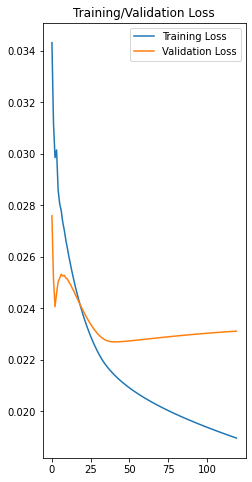

Epoch 1/120
88/88 [==============================] - 1s 13ms/step - loss: 0.0582 - mae: 0.0506 - rmse: 0.0582 - val_loss: 0.2523 - val_mae: 0.2208 - val_rmse: 0.2532
Epoch 2/120
88/88 [==============================] - 1s 13ms/step - loss: 0.0462 - mae: 0.0385 - rmse: 0.0462 - val_loss: 0.2024 - val_mae: 0.1705 - val_rmse: 0.2061
Epoch 3/120
88/88 [==============================] - 1s 13ms/step - loss: 0.0394 - mae: 0.0327 - rmse: 0.0394 - val_loss: 0.1789 - val_mae: 0.1484 - val_rmse: 0.1843
Epoch 4/120
88/88 [==============================] - 1s 13ms/step - loss: 0.0374 - mae: 0.0310 - rmse: 0.0374 - val_loss: 0.1721 - val_mae: 0.1423 - val_rmse: 0.1780
Epoch 5/120
88/88 [==============================] - 1s 13ms/step - loss: 0.0361 - mae: 0.0300 - rmse: 0.0361 - val_loss: 0.1695 - val_mae: 0.1403 - val_rmse: 0.1755
Epoch 6/120
88/88 [==============================] - 1s 13ms/step - loss: 0.0352 - mae: 0.0292 - rmse: 0.0352 - val_loss: 0.1675 - val_mae: 0.1387 - val_rmse: 0.1735
Epoc

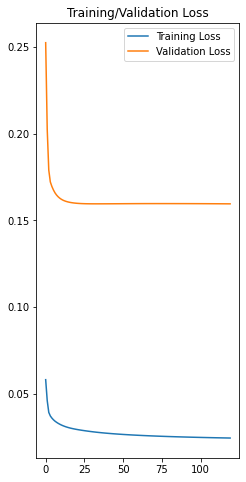

[array([[102.198364,  87.93966 ,  69.25833 ,  72.807884,  88.433846,
         86.68899 ,  79.73483 ,  85.668655,  58.052895,  44.385227,
        107.04337 ,  59.534824,  81.7362  ,  68.052895, 107.88441 ,
         72.568405, 120.78668 ,  72.24099 ,  95.3475  ,  84.53971 ,
         74.862015,  78.49972 ,  55.428864,  66.55989 ,  67.56266 ,
         39.656963,  77.37683 ,  41.529564,  84.94223 ,  84.94637 ,
         78.83317 , 103.079155, 107.45502 , 115.81567 ,  82.953316,
         66.192184,  76.96658 ,  57.85323 ,  80.36054 , 113.24886 ,
         85.2832  ,  71.35415 , 101.041145,  82.23175 ,  94.433624,
         71.39139 ,  94.53149 ,  69.755875,  78.100334, 101.62109 ,
         65.04395 , 108.16886 ,  96.979866,  97.10409 ,  69.3608  ,
         85.34286 ,  93.15183 ,  88.83204 ,  41.46185 ,  57.67443 ,
         63.8882  ,  74.13417 ,  87.39844 ,  66.543526, 105.15386 ,
         95.131134,  58.83566 ,  87.406166,  82.48651 ,  91.7738  ,
         79.62344 , 102.98027 ,  84.06421 ,  88

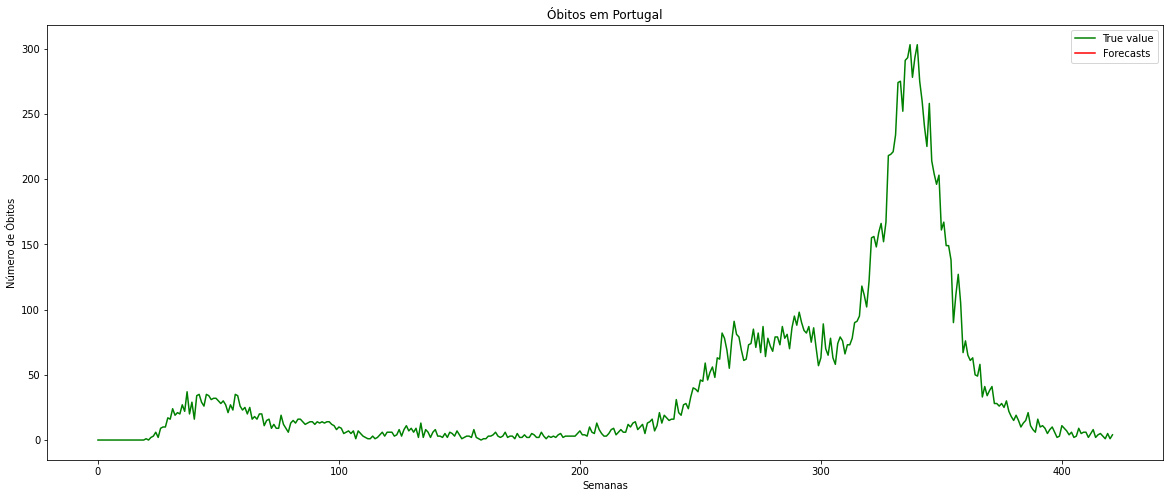

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/50
90/90 [==============================] - 6s 22ms/step - loss: 0.1606 - mae: 0.1384 - rmse: 0.1606 - val_loss: 0.0197 - val_mae: 0.0175 - val_rmse: 0.0197
Epoch 2/50
90/90 [==============================] - 1s 12ms/step - loss: 0.0296 - mae: 0.0270 - rmse: 0.0296 - val_loss: 0.0256 - val_mae: 0.0221 - val_rmse: 0.0256
Epoch 3/50
90/90 [==============================] - 1s 12ms/step - loss: 0.0290 - mae: 0.0263 - rmse: 0.0290 - val_loss: 0.0231 - val_mae: 0.0194 - val_rmse: 0.0231
Epoch 4/50
90/90 [==============================] - 1s 12ms/step - loss: 0.0299 - mae: 0.0274 - rmse: 0.0299 - val_loss: 0.0240 - val_mae: 0.0200 - val_rmse: 0.0240
Epoch 5/50
90/90 [==============================] - 1s 13ms/step - loss: 0.0293 - mae: 0.0270 - rmse: 0.0293 - val_loss: 0.0233 - val_mae: 0.0194 - val_rmse: 0.0233
Epoch

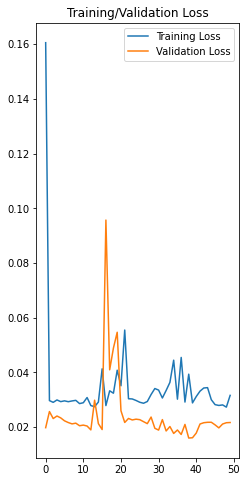

Epoch 1/50
177/177 [==============================] - 2s 12ms/step - loss: 0.0239 - mae: 0.0212 - rmse: 0.0239 - val_loss: 0.0235 - val_mae: 0.0232 - val_rmse: 0.0235
Epoch 2/50
177/177 [==============================] - 2s 12ms/step - loss: 0.0231 - mae: 0.0208 - rmse: 0.0231 - val_loss: 0.0233 - val_mae: 0.0230 - val_rmse: 0.0233
Epoch 3/50
177/177 [==============================] - ETA: 0s - loss: 0.0240 - mae: 0.0215 - rmse: 0.02 - 2s 12ms/step - loss: 0.0240 - mae: 0.0215 - rmse: 0.0240 - val_loss: 0.0236 - val_mae: 0.0233 - val_rmse: 0.0236
Epoch 4/50
177/177 [==============================] - 2s 12ms/step - loss: 0.0227 - mae: 0.0208 - rmse: 0.0227 - val_loss: 0.0236 - val_mae: 0.0234 - val_rmse: 0.0236
Epoch 5/50
177/177 [==============================] - 2s 12ms/step - loss: 0.0230 - mae: 0.0206 - rmse: 0.0230 - val_loss: 0.0233 - val_mae: 0.0231 - val_rmse: 0.0233
Epoch 6/50
177/177 [==============================] - 2s 12ms/step - loss: 0.0202 - mae: 0.0184 - rmse: 0.0202 - 

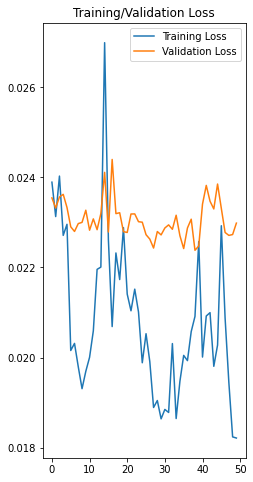

Epoch 1/50
264/264 [==============================] - 3s 12ms/step - loss: 0.0276 - mae: 0.0269 - rmse: 0.0276 - val_loss: 0.1542 - val_mae: 0.1535 - val_rmse: 0.1542
Epoch 2/50
264/264 [==============================] - 3s 12ms/step - loss: 0.0497 - mae: 0.0486 - rmse: 0.0497 - val_loss: 0.1520 - val_mae: 0.1516 - val_rmse: 0.1520
Epoch 3/50
264/264 [==============================] - 3s 12ms/step - loss: 0.0360 - mae: 0.0350 - rmse: 0.0360 - val_loss: 0.1572 - val_mae: 0.1570 - val_rmse: 0.1572
Epoch 4/50
264/264 [==============================] - 3s 12ms/step - loss: 0.0301 - mae: 0.0292 - rmse: 0.0301 - val_loss: 0.1542 - val_mae: 0.1540 - val_rmse: 0.1542
Epoch 5/50
264/264 [==============================] - 3s 12ms/step - loss: 0.0282 - mae: 0.0272 - rmse: 0.0282 - val_loss: 0.1737 - val_mae: 0.1734 - val_rmse: 0.1737
Epoch 6/50
264/264 [==============================] - 3s 12ms/step - loss: 0.0283 - mae: 0.0276 - rmse: 0.0283 - val_loss: 0.1598 - val_mae: 0.1594 - val_rmse: 0.159

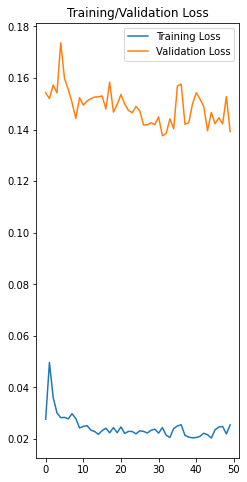

[array([[39.154087, 40.20269 , 41.22899 , 38.513752, 44.67425 , 43.26498 ,
        41.432682, 38.331688, 40.717316, 38.408726, 42.01934 , 42.51613 ,
        42.157166, 47.007866, 38.61974 , 43.701557, 41.397057, 37.967976,
        40.280437, 37.298626, 39.17956 , 42.63641 , 40.30856 , 42.32016 ,
        42.62496 , 42.628048, 44.01679 , 39.204197, 45.892242, 43.25191 ,
        42.250168, 42.974895, 45.041626, 43.82612 , 41.831432, 39.006996,
        44.148766, 39.188644, 41.53055 , 41.32412 , 45.182205, 43.090084,
        44.963814, 38.952534, 44.605804, 38.760094, 43.436802, 41.11491 ,
        43.14783 , 42.156803, 39.961765, 38.87243 , 43.21291 , 40.319603,
        39.22443 , 44.97791 , 39.66144 , 40.634556, 39.39763 , 39.970554,
        39.684532, 43.083626, 39.33177 , 43.270344, 42.200882, 40.709305,
        42.8552  , 40.44058 , 45.41762 , 43.80768 , 41.925037, 41.562046,
        43.269142, 41.94094 , 42.693687, 39.634975, 43.436615]],
      dtype=float32)]
Previsões:
[39.154087]


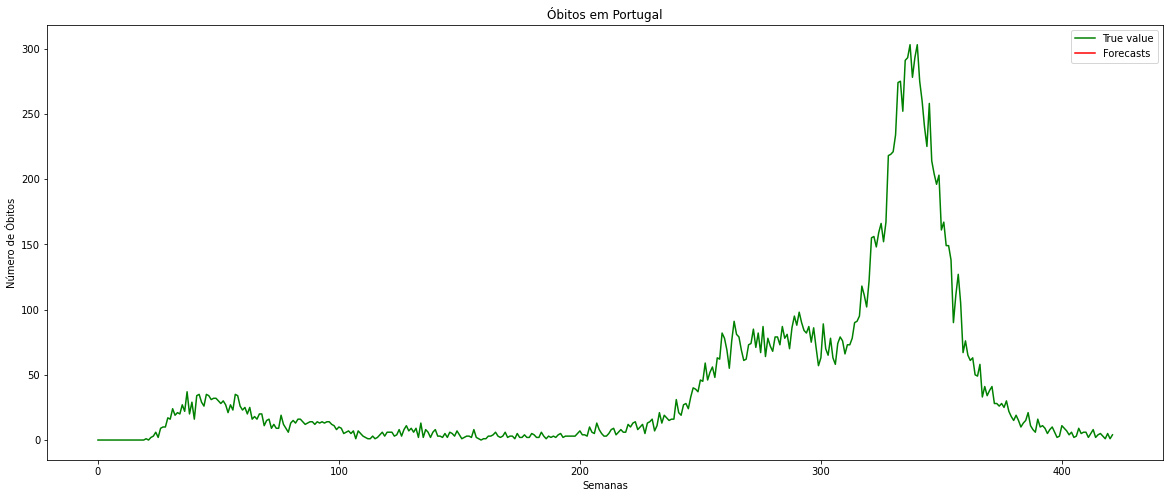

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/90
45/45 [==============================] - 5s 34ms/step - loss: 0.8170 - mae: 0.7964 - rmse: 0.8170 - val_loss: 0.8084 - val_mae: 0.7744 - val_rmse: 0.8079
Epoch 2/90
45/45 [==============================] - 1s 13ms/step - loss: 0.6607 - mae: 0.6039 - rmse: 0.6607 - val_loss: 0.6130 - val_mae: 0.5446 - val_rmse: 0.6125
Epoch 3/90
45/45 [==============================] - 1s 13ms/step - loss: 0.4438 - mae: 0.3703 - rmse: 0.4438 - val_loss: 0.3678 - val_mae: 0.2878 - val_rmse: 0.3674
Epoch 4/90
45/45 [==============================] - 1s 13ms/step - loss: 0.2211 - mae: 0.1610 - rmse: 0.2211 - val_loss: 0.1457 - val_mae: 0.0903 - val_rmse: 0.1454
Epoch 5/90
45/45 [==============================] - 1s 14ms/step - loss: 0.0816 - mae: 0.0678 - rmse: 0.0816 - val_loss: 0.0347 - val_mae: 0.0292 - val_rmse: 0.0347
Epoch

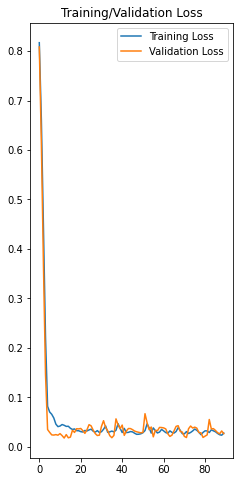

Epoch 1/90
89/89 [==============================] - 4s 15ms/step - loss: 0.0247 - mae: 0.0219 - rmse: 0.0246 - val_loss: 0.0215 - val_mae: 0.0200 - val_rmse: 0.0222
Epoch 2/90
89/89 [==============================] - 1s 14ms/step - loss: 0.0209 - mae: 0.0183 - rmse: 0.0208 - val_loss: 0.0257 - val_mae: 0.0240 - val_rmse: 0.0266
Epoch 3/90
89/89 [==============================] - 1s 14ms/step - loss: 0.0221 - mae: 0.0196 - rmse: 0.0221 - val_loss: 0.0244 - val_mae: 0.0227 - val_rmse: 0.0252
Epoch 4/90
89/89 [==============================] - 1s 14ms/step - loss: 0.0248 - mae: 0.0222 - rmse: 0.0247 - val_loss: 0.0232 - val_mae: 0.0217 - val_rmse: 0.0240
Epoch 5/90
89/89 [==============================] - 1s 14ms/step - loss: 0.0268 - mae: 0.0241 - rmse: 0.0267 - val_loss: 0.0225 - val_mae: 0.0212 - val_rmse: 0.0233
Epoch 6/90
89/89 [==============================] - 1s 14ms/step - loss: 0.0259 - mae: 0.0232 - rmse: 0.0258 - val_loss: 0.0225 - val_mae: 0.0212 - val_rmse: 0.0233
Epoch 7/90

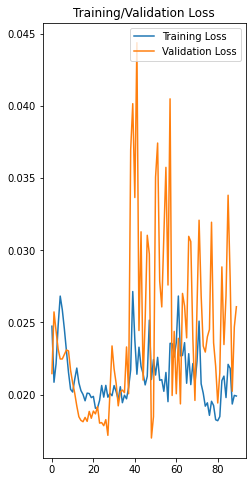

Epoch 1/90
132/132 [==============================] - 2s 13ms/step - loss: 0.0385 - mae: 0.0344 - rmse: 0.0385 - val_loss: 0.1539 - val_mae: 0.1406 - val_rmse: 0.1631
Epoch 2/90
132/132 [==============================] - 2s 13ms/step - loss: 0.0615 - mae: 0.0566 - rmse: 0.0615 - val_loss: 0.1997 - val_mae: 0.1829 - val_rmse: 0.2075
Epoch 3/90
132/132 [==============================] - 2s 13ms/step - loss: 0.0450 - mae: 0.0407 - rmse: 0.0450 - val_loss: 0.1666 - val_mae: 0.1538 - val_rmse: 0.1758
Epoch 4/90
132/132 [==============================] - 2s 13ms/step - loss: 0.0424 - mae: 0.0388 - rmse: 0.0424 - val_loss: 0.1894 - val_mae: 0.1804 - val_rmse: 0.2013
Epoch 5/90
132/132 [==============================] - 2s 13ms/step - loss: 0.0391 - mae: 0.0350 - rmse: 0.0391 - val_loss: 0.1643 - val_mae: 0.1561 - val_rmse: 0.1759
Epoch 6/90
132/132 [==============================] - 2s 13ms/step - loss: 0.0331 - mae: 0.0288 - rmse: 0.0331 - val_loss: 0.1796 - val_mae: 0.1712 - val_rmse: 0.191

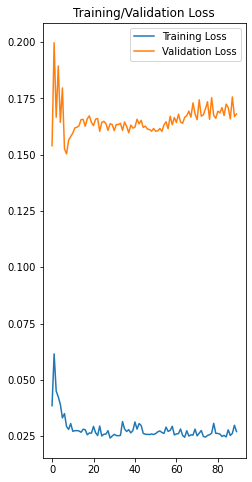

[array([[50.61675 , 47.160538, 42.968952, 44.939297, 48.709976, 43.00467 ,
        45.353767, 48.97224 , 54.97464 , 50.04029 , 52.20229 , 47.821613,
        41.486763, 50.685368, 47.18425 , 51.905308, 46.190857, 50.65323 ,
        44.865963, 42.490818, 42.14109 , 44.11051 , 45.890102, 43.443775,
        46.881546, 44.407475, 46.96518 , 50.66054 , 39.623825, 46.166557,
        45.383232, 39.88458 , 43.9951  , 43.93412 , 47.80469 , 45.249706,
        46.408077, 49.6886  , 47.835087, 47.922997, 44.58823 , 43.329407,
        46.18742 , 47.78796 , 43.372852, 46.160717, 42.294064, 45.90159 ,
        47.17234 , 45.39221 , 46.928997, 49.677082, 47.74688 , 41.954258,
        50.096687, 45.735165, 53.42145 , 42.957115, 49.428856, 49.231186,
        43.901257, 51.241894, 50.048267, 49.841244, 43.142937, 43.775658,
        49.802944, 50.838985, 51.954144, 48.99487 , 48.533855, 45.479828,
        42.46303 , 44.931293, 47.4013  , 45.172535, 45.122707]],
      dtype=float32)]
Previsões:
[50.61675]


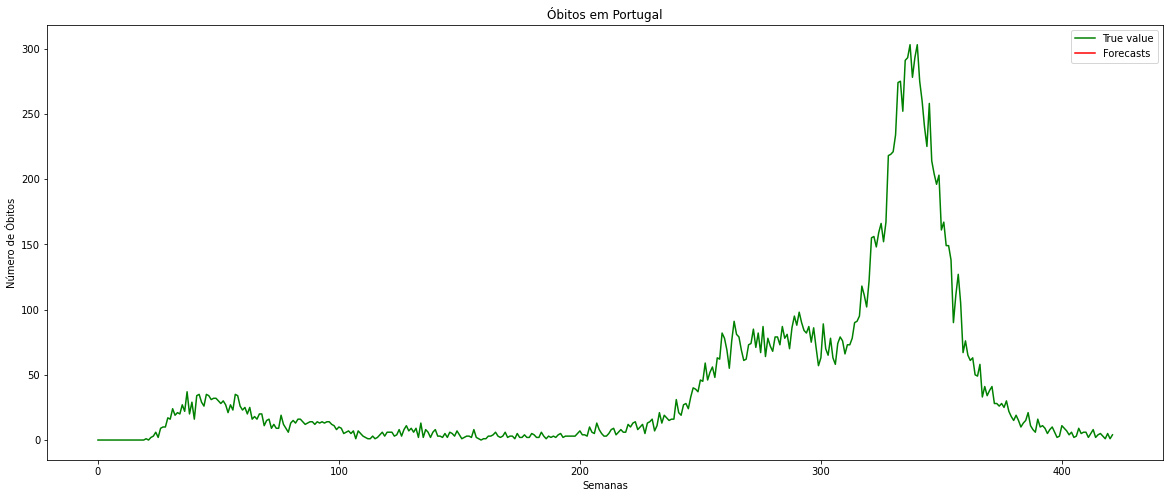

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/120
30/30 [==============================] - 4s 45ms/step - loss: 0.9049 - mae: 0.8937 - rmse: 0.9049 - val_loss: 0.9689 - val_mae: 0.9560 - val_rmse: 0.9689
Epoch 2/120
30/30 [==============================] - 0s 14ms/step - loss: 0.8918 - mae: 0.8803 - rmse: 0.8918 - val_loss: 0.9562 - val_mae: 0.9428 - val_rmse: 0.9562
Epoch 3/120
30/30 [==============================] - 0s 13ms/step - loss: 0.8785 - mae: 0.8662 - rmse: 0.8785 - val_loss: 0.9432 - val_mae: 0.9289 - val_rmse: 0.9432
Epoch 4/120
30/30 [==============================] - 0s 13ms/step - loss: 0.8651 - mae: 0.8515 - rmse: 0.8651 - val_loss: 0.9300 - val_mae: 0.9146 - val_rmse: 0.9300
Epoch 5/120
30/30 [==============================] - 0s 13ms/step - loss: 0.8518 - mae: 0.8366 - rmse: 0.8518 - val_loss: 0.9168 - val_mae: 0.9002 - val_rmse: 0.9168


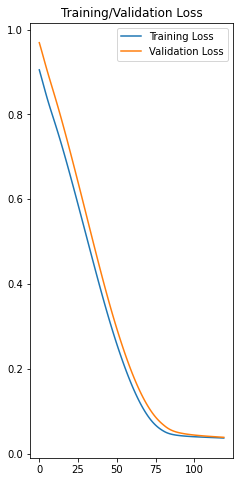

Epoch 1/120
59/59 [==============================] - 1s 13ms/step - loss: 0.0399 - mae: 0.0343 - rmse: 0.0399 - val_loss: 0.0320 - val_mae: 0.0257 - val_rmse: 0.0320
Epoch 2/120
59/59 [==============================] - 1s 13ms/step - loss: 0.0367 - mae: 0.0315 - rmse: 0.0367 - val_loss: 0.0298 - val_mae: 0.0245 - val_rmse: 0.0305
Epoch 3/120
59/59 [==============================] - 1s 13ms/step - loss: 0.0342 - mae: 0.0291 - rmse: 0.0342 - val_loss: 0.0289 - val_mae: 0.0246 - val_rmse: 0.0300
Epoch 4/120
59/59 [==============================] - 1s 13ms/step - loss: 0.0332 - mae: 0.0284 - rmse: 0.0332 - val_loss: 0.0292 - val_mae: 0.0253 - val_rmse: 0.0306
Epoch 5/120
59/59 [==============================] - 1s 13ms/step - loss: 0.0327 - mae: 0.0279 - rmse: 0.0327 - val_loss: 0.0296 - val_mae: 0.0259 - val_rmse: 0.0311
Epoch 6/120
59/59 [==============================] - 1s 13ms/step - loss: 0.0323 - mae: 0.0275 - rmse: 0.0323 - val_loss: 0.0301 - val_mae: 0.0264 - val_rmse: 0.0316
Epoc

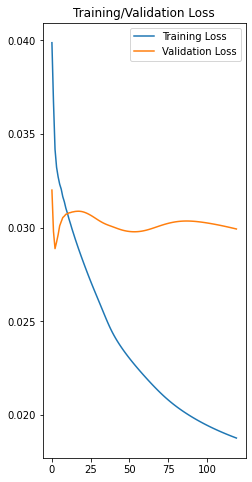

Epoch 1/120
88/88 [==============================] - 1s 13ms/step - loss: 0.0515 - mae: 0.0426 - rmse: 0.0515 - val_loss: 0.1956 - val_mae: 0.1600 - val_rmse: 0.1974
Epoch 2/120
88/88 [==============================] - 1s 14ms/step - loss: 0.0448 - mae: 0.0369 - rmse: 0.0448 - val_loss: 0.1758 - val_mae: 0.1431 - val_rmse: 0.1791
Epoch 3/120
88/88 [==============================] - 1s 13ms/step - loss: 0.0428 - mae: 0.0354 - rmse: 0.0428 - val_loss: 0.1658 - val_mae: 0.1347 - val_rmse: 0.1698
Epoch 4/120
88/88 [==============================] - 1s 13ms/step - loss: 0.0413 - mae: 0.0342 - rmse: 0.0413 - val_loss: 0.1595 - val_mae: 0.1295 - val_rmse: 0.1635
Epoch 5/120
88/88 [==============================] - 1s 13ms/step - loss: 0.0402 - mae: 0.0333 - rmse: 0.0402 - val_loss: 0.1544 - val_mae: 0.1253 - val_rmse: 0.1584
Epoch 6/120
88/88 [==============================] - 1s 12ms/step - loss: 0.0391 - mae: 0.0323 - rmse: 0.0391 - val_loss: 0.1502 - val_mae: 0.1217 - val_rmse: 0.1541
Epoc

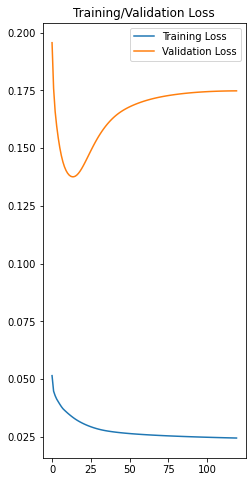

[array([[ 80.410904, 112.2065  ,  71.62563 ,  64.283745,  66.23185 ,
         55.373905,  35.118263,  84.432976,  90.98035 ,  60.728294,
         78.31088 ,  68.98432 ,  71.43132 ,  73.12562 ,  35.0222  ,
         75.78227 ,  85.72514 ,  42.592686,  88.41106 ,  86.89182 ,
         53.688816,  73.067665, 103.15269 ,  86.4536  ,  67.22411 ,
         63.67074 ,  81.11487 , 111.89657 ,  19.563341, 100.869995,
         84.25566 ,  68.49315 ,  93.80154 ,  76.78805 ,  83.37972 ,
         76.47743 ,  68.25905 , 100.22552 ,  82.69017 ,  79.281876,
         77.51981 ,  63.858444,  76.83993 ,  57.18211 ,  81.20813 ,
         99.3738  ,  63.551052,  86.95754 ,  87.36083 ,  78.8531  ,
         91.24651 ,  57.105003, 101.527245,  88.892746,  52.190224,
         59.7286  ,  66.353195,  79.13916 ,  77.70374 ,  58.164867,
         50.449833,  74.641655,  64.94074 ,  65.064995,  49.091003,
         79.55648 , 112.70478 ,  88.36715 ,  39.678493,  86.31901 ,
         89.12432 ,  70.09814 ,  90.25376 ,  78

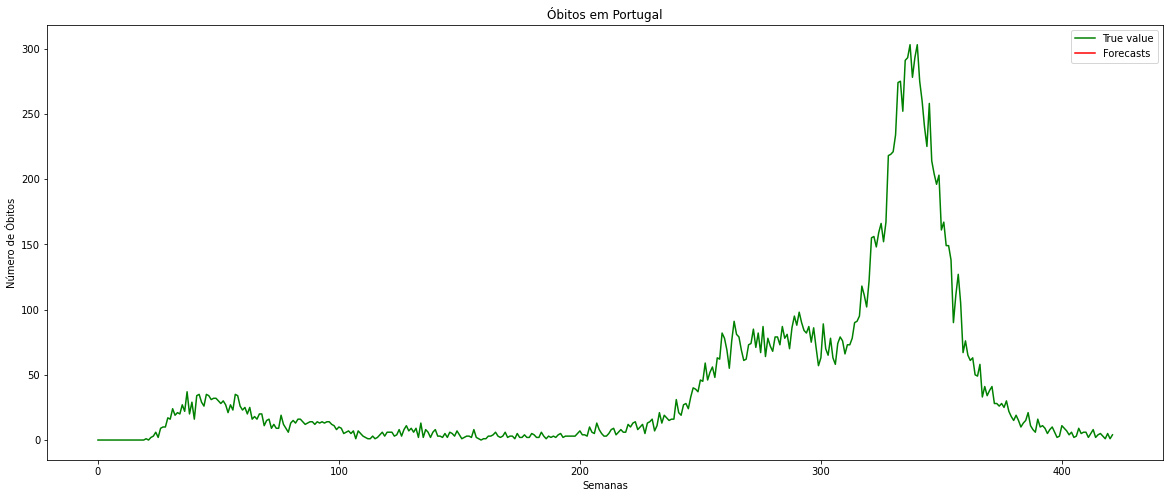

In [21]:
for t in tunning_dict:
    #print(record[r])
    # fitting the model
    timesteps = tunning_dict[t]['timesteps']
    epochs = tunning_dict[t]['epochs']
    batch_size= tunning_dict[t]['batch_size']
    multisteps= tunning_dict[t]['multisteps']
    cv_splits = tunning_dict[t]['cv_splits']
    learning_rate = tunning_dict[t]['learning_rate']

    #print(timesteps,epochs,batch_size,cv_splits)

    X, y = to_supervised(df, timesteps)

    model = build_model(timesteps, n_variate)
    model, history = compile_and_fit(model, epochs, batch_size,learning_rate)
    path_to_save=r'modelo_'+str(t)+'.h5'
    model.save(path_to_save)
    #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
    forecasts = forecast(model, df, timesteps, multisteps, scaler)

    print(forecasts)

    prev = []

    #plot do valor previsto da ação de Open
    for f in forecasts:
        prev.append(f[0][0])

    print('Previsões:')
    print(prev)
    plot_forecast(df_raw, prev)

    #Scorer
  

    record[t] = history

In [22]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
    loss = []
    mae =[]
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
        #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
        #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
        #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
        #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
        loss.append(sum(h.history['loss'])/len(h.history['loss']))
        mae.append(sum(h.history['mae'])/len(h.history['mae']))
        rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
        val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
        val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
        val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
        id_split+=1
    id_split=1
  
    final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

    id_tunning=id_tunning+1

In [23]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.029255932122468947, 0.027268520469466845, 0.029255932122468947, 0.06295802352329095, 0.06165603045374155, 0.06295802352329095] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.042193191883464654, 0.037513106291492786, 0.04216323589285215, 0.07894705603520076, 0.07236762702465056, 0.08073426232983669] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.12938145137081544, 0.1120614300854504, 0.12938144854580363, 0.20098823425670465, 0.17713051888470846, 0.20059903034319482] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.02626048900807897, 0.02470140243983931, 0.02626048900807897, 0.06714688817866975, 0.0660045711323619, 0.06714688817866975] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.03560942269999672, 0.03159251417964697, 0.035583421753512486, 0.0806510489847925, 0.07516777170822

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.029256,0.027269,0.029256,0.062958,0.061656,0.062958
2,0.042193,0.037513,0.042163,0.078947,0.072368,0.080734
3,0.129381,0.112061,0.129381,0.200988,0.177131,0.200599
4,0.026260,0.024701,0.026260,0.067147,0.066005,0.067147
5,0.035609,0.031593,0.035583,0.080651,0.075168,0.083769
6,0.104296,0.092654,0.104296,0.157153,0.137982,0.159326
7,0.026683,0.024955,0.026683,0.065414,0.064258,0.065414
8,0.035191,0.031117,0.035169,0.080621,0.075170,0.084297
9,0.114897,0.101439,0.114897,0.172908,0.153754,0.173413


In [24]:
df.columns

Index(['confirmados_novos', 'recuperados', 'Temperature', 'Visibility',
       'total_testes', 'testes_pcr', 'testes_antigenio',
       'new_cases_per_million_Austria', 'new_deaths_per_million_Austria',
       'new_cases_per_million_Belgium', 'new_deaths_per_million_Belgium',
       'icu_patients_per_million_Belgium', 'hosp_patients_per_million_Belgium',
       'new_deaths_per_million_Bulgaria', 'new_cases_per_million_Canada',
       'new_deaths_per_million_Canada', 'icu_patients_per_million_Canada',
       'new_cases_per_million_Cyprus', 'new_deaths_per_million_Czechia',
       'hosp_patients_per_million_Czechia', 'new_cases_per_million_Denmark',
       'new_tests_per_thousand_Estonia', 'icu_patients_per_million_France',
       'new_cases_per_million_Georgia', 'new_cases_per_million_Germany',
       'new_deaths_per_million_Germany', 'icu_patients_per_million_Germany',
       'new_deaths_per_million_Hungary', 'hosp_patients_per_million_Hungary',
       'positive_rate_India', 'new_cases

In [25]:
#Results metrics to a file
final_df.to_csv(r"resultados_lstm_covid.csv",index=True)